<img src="https://github.com/d9w/evolution/raw/master/imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Algorithms

## Evolving Neural Networks with ES

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson, Yuri Lavinas, Paul Templier | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

In order to visualize the environment in this notebook, you will need to install the following:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install cma swig pyvirtualdisplay pygame box2d-py==2.3.8  > /dev/null 2>&1

In [ ]:
!pip install torch > /dev/null 2>&1

# <a name="neuroevolution">3.</a> ES for Neuroevolution

Evolutionary strategies are intended for continuous optimization and can easily be applied to the optimization of neural network parameters, or *neuroevolution*. 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import numpy as np
import gym

In [3]:
class NeuralNetwork(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(input_shape, 32)
        self.l2 = nn.Linear(32, 32)
        self.lout = nn.Linear(32, n_actions)
        
    def forward(self, x):
        x = F.relu(self.l1(x.float()))
        x = F.relu(self.l2(x))
        return self.lout(x)
    
    def get_params(self):
        p = np.empty((0,))
        for n in self.parameters():
            p = np.append(p, n.flatten().cpu().detach().numpy())
        return p
    
    def set_params(self, x):
        start = 0
        for p in self.parameters():
            e = start + np.prod(p.shape)
            p.data = torch.FloatTensor(x[start:e]).reshape(p.shape)
            start = e

We'll add some visualization functionality to have the environment render directly in the notebook.

In [5]:
from pyvirtualdisplay import Display
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
##pydisplay = Display(visible=0, size=(1400, 900))
##pydisplay.start()
plt.ion();

Following the framework of evolutionary policy search, we will optimize a neural network representing a policy and maximize the total reward over a single episode using this policy.

In [6]:
def evaluate(ann, env, visul=True):
    obs, info = env.reset(seed=0)
    if visul:
        img = plt.imshow(env.render())
    total_reward = 0
    while True:
        # Output of the neural net
        net_output = ann(torch.tensor(obs))
        # the action is the value clipped returned by the nn
        action = net_output.data.cpu().numpy().argmax()
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        if visul:
            img.set_data(env.render())
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
        if done:
            break
    return total_reward

We've configured this for discrete action spaces. We can see a random neural network on different environments like `CartPole-v0`, `MountainCar-v0`, and `LunarLander-v2`.

In [7]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)

-393.81879004371956

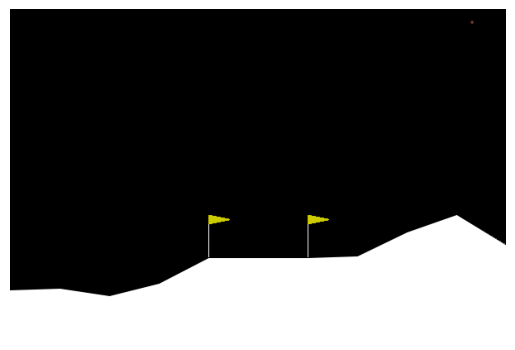

In [8]:
evaluate(ann, env, visul=True)

In order to evolve the parameters of this neural network, we will modify the parameters of the network using `set_params` with the genes of the new individual. In the evolutionary literature, this is referred to as a *direct encoding* as the neural network parameters are directly encoded in the genome.

In [9]:
def fitness(x, ann, env, visul=False):
    ann.set_params(x)
    return -evaluate(ann, env, visul=visul)

In [10]:
p = ann.get_params()
np.shape(p)

(1476,)

We can first observe a random individual $x$.

-119.05972648524923

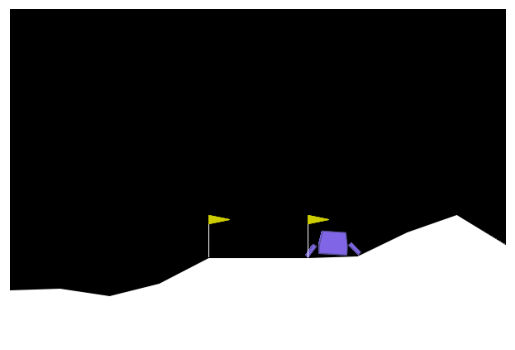

In [12]:
x = np.random.rand(len(p))
-fitness(x, ann, env, visul=True)

Let's try optimizing the policy using the simple $(\mu, \lambda)$ ES we proposed.

In [13]:
def mu_lambda(x, fitness, gens=200, lam=10, alpha=0.2, verbose=False):
    x_best = x
    f_best = fitness(x)
    fits = np.zeros(gens)
    for g in range(gens):
        N = np.random.normal(size=(lam, len(x)))
        F = np.zeros(lam)
        for i in range(lam):
            ind = x + N[i, :]
            F[i] = fitness(ind)
            if F[i] < f_best:
                f_best = F[i]
                x_best = ind
                if verbose:
                    print(g, " ", f_best)
        fits[g] = f_best
        mu_f = np.mean(F)
        std_f = np.std(F)
        A = F
        if std_f != 0:
            A = (F - mu_f) / std_f
        x = x - alpha * np.dot(A, N) / lam
    return fits, x_best

In [14]:
np.random.seed(654)
env = gym.make('LunarLander-v2', render_mode='rgb_array')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
x = np.random.randn(len(ann.get_params()))
f = lambda x : fitness(x, ann, env)
fits, x = mu_lambda(x, f, gens=10, lam=10, alpha=0.1, verbose=True)

0   119.05972648524923
0   92.39580818896748
3   20.5819124547384


In [15]:
fits

array([92.39580819, 92.39580819, 92.39580819, 20.58191245, 20.58191245,
       20.58191245, 20.58191245, 20.58191245, 20.58191245, 20.58191245])

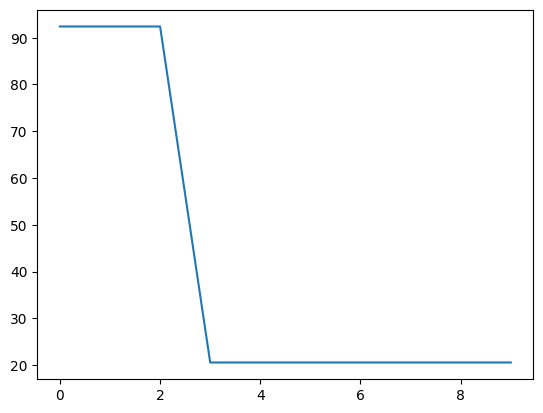

In [16]:
plt.plot(fits);

-20.5819124547384

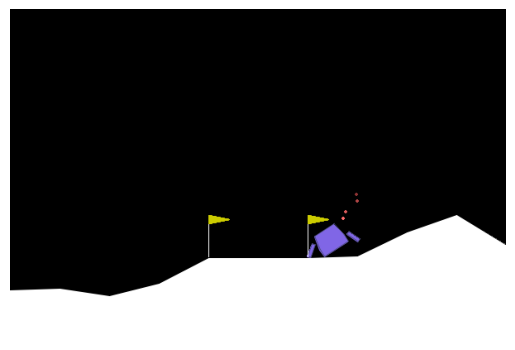

In [17]:
-fitness(x, ann, env, visul=True)

# CMA-ES for Neuroevolution

We will now use CMA-ES for the Lunar Lander problem

In [18]:
import cma
np.random.seed(123)
env = gym.make('LunarLander-v2', render_mode='rgb_array')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
es = cma.CMAEvolutionStrategy(len(ann.get_params()) * [0], 0.1, {'seed': 123})

(12_w,25)-aCMA-ES (mu_w=7.3,w_1=23%) in dimension 1476 (seed=123, Sun Apr 21 19:03:18 2024)


In [19]:
for i in range(20):
    solutions = np.array(es.ask())
    fits = [fitness(x, ann, env) for x in solutions]
    es.tell(solutions, fits)
    es.disp()

c:\Users\benab\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     25 -2.200048756713315e+00 1.0e+00 9.94e-02  1e-01  1e-01 0:00.5
    2     50 1.190597264852492e+02 1.0e+00 9.89e-02  1e-01  1e-01 0:00.9
    3     75 1.190597264852492e+02 1.0e+00 9.84e-02  1e-01  1e-01 0:01.2
   13    325 1.423302271057308e+01 1.0e+00 9.43e-02  9e-02  9e-02 0:05.2


29.670667947015517

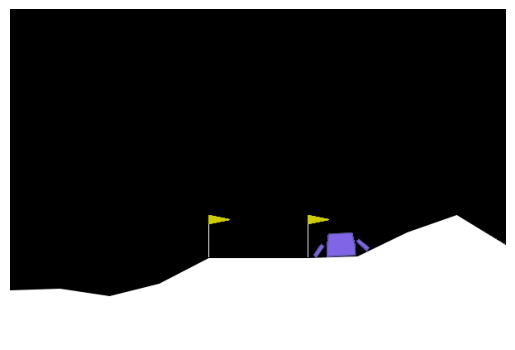

In [21]:
x = es.result[0]
-fitness(x, ann, env, visul=True)

The results on LunarLander clearly show the benefits of CMA-ES; we have found a reasonable policy in a small number of generations. Applying CMA-ES to larger neural networks remains an open challenge, however, due to the vast number of parameters in ANNs. Specifically, CMA-ES calculates the covariance of all parameters, which is $O(n^2)$.

In [22]:
np.shape(es.sm.C)

(1476, 1476)

<div class="alert alert-success">
    <h3>Exercise 1</h3>
    
The network used has 2 layers of 32 neurons each. Try changing this and noticing the impact on the number of total parameters for CMA-ES. How large of a network can CMA-ES optimize?
</div>

<div class="alert alert-success">
    <h3>Exercise 2</h3>
    
Compare the $(1+\lambda)$ ES, $(\mu,\lambda)$ ES, and CMA-ES algorithms on Lunar Lander. Is one significantly better than the others, consistently across different initializations?
</div>